In [5]:
# Install PyTorch (GPU) first
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

# Install PyTorch Geometric and its extensions from precompiled wheels
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.3.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.3.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.3.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.3.0+cu118.html
!pip install torch-geometric

# Extra dependencies
!pip install numpy matplotlib tqdm imageio

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 70.1 MB/s eta 0:00:0000:010:01
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 42.6 MB/s eta 0:00:0000:0100:01
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 12.1 MB/s eta 0:00:0000:010:01
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.1/906.1 kB 10.6 MB/s eta 0:00:0000:0100:01
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import imageio

import os
import numpy as np
import torch.nn.functional as F
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from sklearn.neighbors import NearestNeighbors
from IPython.display import FileLink

## Small utilities & reproducibility

In [8]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

## N-body simulator

In [9]:
G = 1.0  # gravitational constant (arbitrary units)

def plummer_sphere(n, scale_radius=1.0, total_mass=1.0, rng=None):
    """Return (pos, vel, masses) for n particles in a Plummer-like sphere."""
    if rng is None:
        rng = np.random.default_rng()
    u = rng.random(n)
    # approximate Plummer radial sampling
    r = scale_radius * (u ** (-2.0/3.0) - 1.0) ** (-0.5)
    cost = rng.uniform(-1.0, 1.0, n)
    sint = np.sqrt(1 - cost**2)
    phi = rng.uniform(0, 2*np.pi, n)
    x = r * sint * np.cos(phi)
    y = r * sint * np.sin(phi)
    z = r * cost
    pos = np.vstack([x, y, z]).T
    # small random velocities (bound-ish)
    vscale = np.sqrt(G * total_mass / (scale_radius + 1e-8))
    vel = rng.normal(0, 0.25 * vscale, size=(n, 3))
    masses = np.full(n, total_mass / n, dtype=np.float32)
    return pos.astype(np.float32), vel.astype(np.float32), masses

def build_two_galaxies(n1=100, n2=100, sep=8.0, vrel=0.8, m1=1.0, m2=1.0, scale1=1.0, scale2=1.0, rng_seed=None):
    """Combine two Plummer spheres separated and with bulk velocities toward/away from each other."""
    rng = np.random.default_rng(rng_seed)
    p1, v1, m_1 = plummer_sphere(n1, scale1, m1, rng=rng)
    p2, v2, m_2 = plummer_sphere(n2, scale2, m2, rng=rng)
    p1 += np.array([-sep/2.0, 0.0, 0.0])
    p2 += np.array([sep/2.0, 0.0, 0.0])
    v1 += np.array([vrel/2.0, 0.0, 0.0])
    v2 += np.array([-vrel/2.0, 0.0, 0.0])
    pos = np.vstack([p1, p2])
    vel = np.vstack([v1, v2])
    masses = np.concatenate([m_1, m_2])
    return pos, vel, masses

def compute_accelerations(positions, masses, softening=0.1):
    """Naive O(N^2) pairwise gravitational acceleration (softened)."""
    N = positions.shape[0]
    acc = np.zeros_like(positions, dtype=np.float32)
    for i in range(N):
        r_ij = positions - positions[i:i+1]  # (N,3)
        dist2 = (r_ij**2).sum(axis=1) + softening**2
        inv_dist3 = dist2 ** -1.5
        inv_dist3[i] = 0.0  # remove self
        coef = G * masses * inv_dist3
        a = (r_ij * coef[:, None]).sum(axis=0)
        acc[i] = a
    return acc

def integrate(pos0, vel0, masses, dt=0.02, steps=50, softening=0.1, integrator='leapfrog'):
    """Integrate and return (positions: (T,N,3), velocities: (T,N,3))."""
    pos = pos0.copy()
    vel = vel0.copy()
    positions = [pos.copy()]
    velocities = [vel.copy()]
    if integrator == 'euler':
        for _ in range(steps):
            a = compute_accelerations(pos, masses, softening)
            vel += a * dt
            pos += vel * dt
            positions.append(pos.copy()); velocities.append(vel.copy())
    else:
        # leapfrog: kick-drift-kick
        a = compute_accelerations(pos, masses, softening)
        vel_half = vel + 0.5 * a * dt
        for _ in range(steps):
            pos = pos + vel_half * dt
            a = compute_accelerations(pos, masses, softening)
            vel_half = vel_half + a * dt
            vel = vel_half - 0.5 * a * dt
            positions.append(pos.copy()); velocities.append(vel.copy())
    return np.stack(positions).astype(np.float32), np.stack(velocities).astype(np.float32)

## Dataset builder: snapshots -> PyG Data objects

In [10]:
def snapshot_to_graph(pos, vel, masses, k=8):
    """
    Convert a single snapshot into a torch_geometric Data object.
    Node features: [x,y,z, vx,vy,vz, mass]
    Edges: kNN spatial edges (directed: from node -> neighbor).
    """
    N = pos.shape[0]
    x = np.hstack([pos, vel, masses.reshape(-1,1)]).astype(np.float32)  # (N,7)
    # compute kNN (exclude self)
    nbrs = NearestNeighbors(n_neighbors=min(k+1, N), algorithm='auto').fit(pos)
    _, idxs = nbrs.kneighbors(pos)
    rows = np.repeat(np.arange(N), idxs.shape[1]-1)
    cols = idxs[:,1:].reshape(-1)
    edge_index = np.vstack([rows, cols]).astype(np.int64)  # shape (2,E)
    # torch Data
    data = Data(x=torch.tensor(x, dtype=torch.float32), edge_index=torch.tensor(edge_index, dtype=torch.long))
    return data

class GalaxyDataset(InMemoryDataset):
    """Build dataset from list of trajectories: [(pos_traj, vel_traj, masses), ...]"""
    def __init__(self, traj_list, k=8, transform=None, pre_transform=None):
        super().__init__('.', transform, pre_transform)
        data_list = []
        for pos_traj, vel_traj, masses in traj_list:
            T = pos_traj.shape[0]
            for t in range(T-1):
                pos_t = pos_traj[t]        # (N,3)
                vel_t = vel_traj[t]        # (N,3)
                pos_t1 = pos_traj[t+1]
                vel_t1 = vel_traj[t+1]
                d = snapshot_to_graph(pos_t, vel_t, masses, k=k)
                # store ground truth next-step absolute positions & velocities
                d.y_pos = torch.tensor(pos_t1, dtype=torch.float32)
                d.y_vel = torch.tensor(vel_t1, dtype=torch.float32)
                data_list.append(d)
        self.data, self.slices = self.collate(data_list)

## GNN model (PyG): message passing

In [11]:
from torch_geometric.nn import MessagePassing

class EdgeMP(MessagePassing):
    """Simple MLP-based message passing (concat x_i and x_j)."""
    def __init__(self, in_channels, hidden_channels):
        super().__init__(aggr='add')
        self.mlp = nn.Sequential(
            nn.Linear(in_channels*2, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU()
        )
    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)
    def message(self, x_i, x_j):
        # concat target (x_i) and source (x_j)
        m = torch.cat([x_i, x_j], dim=-1)
        return self.mlp(m)
    def update(self, aggr_out):
        return aggr_out

class GalaxyGNN(nn.Module):
    def __init__(self, node_in=7, hidden=128, num_layers=3):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(node_in, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )
        self.layers = nn.ModuleList([EdgeMP(hidden, hidden) for _ in range(num_layers)])
        self.dec = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 6)  # predict next pos (3) and next vel (3)
        )
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = self.enc(x)
        for layer in self.layers:
            m = layer(h, edge_index)
            h = h + m  # residual
        out = self.dec(h)
        pos_pred = out[:, :3]
        vel_pred = out[:, 3:6]
        return pos_pred, vel_pred

## Training & utilities

In [12]:
def generate_trajectories(num_sims=8, n_per_sim=(80,80), steps=40, dt=0.03, seed=123):
    """Generate multiple simulated collisions with randomized parameters."""
    rng = np.random.default_rng(seed)
    trajs = []
    for i in range(num_sims):
        n1, n2 = n_per_sim
        sep = float(rng.uniform(4.0, 12.0))
        vrel = float(rng.uniform(0.0, 2.0))
        m1 = float(rng.uniform(0.5, 3.0))
        m2 = float(rng.uniform(0.5, 3.0))
        scale1 = float(rng.uniform(0.5, 2.0))
        scale2 = float(rng.uniform(0.5, 2.0))
        # use different RNG seed for each sim to vary particle draws
        sim_seed = int(rng.integers(1, 2**30))
        pos0, vel0, masses = build_two_galaxies(n1, n2, sep=sep, vrel=vrel, m1=m1, m2=m2, scale1=scale1, scale2=scale2, rng_seed=sim_seed)
        pos_traj, vel_traj = integrate(pos0, vel0, masses, dt=dt, steps=steps)
        trajs.append((pos_traj, vel_traj, masses))
    return trajs

def train_model(dataset, device='cpu', epochs=12, batch_size=1, lr=1e-3, save_path='/kaggle/working/gnn_galaxy.pt'):
    # create indices split
    n = len(dataset)
    idx = np.arange(n)
    np.random.shuffle(idx)
    split = int(0.8 * n)
    train_idx, val_idx = idx[:split], idx[split:]
    from torch.utils.data import Subset
    train_ds = Subset(dataset, train_idx)
    val_ds = Subset(dataset, val_idx)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    model = GalaxyGNN().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_val = float('inf')

    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch} [train]"):
            batch = batch.to(device)
            opt.zero_grad()
            pos_pred, vel_pred = model(batch)
            # targets (concatenated across batch)
            y_pos = batch.y_pos.to(device)
            y_vel = batch.y_vel.to(device)
            loss = F.mse_loss(pos_pred, y_pos) + F.mse_loss(vel_pred, y_vel)
            loss.backward()
            opt.step()
            train_loss += loss.item() * batch.num_graphs
        train_loss /= len(train_ds)

        # validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch} [val]"):
                batch = batch.to(device)
                pos_pred, vel_pred = model(batch)
                loss = F.mse_loss(pos_pred, batch.y_pos.to(device)) + F.mse_loss(vel_pred, batch.y_vel.to(device))
                val_loss += loss.item() * batch.num_graphs
        val_loss /= len(val_ds)

        print(f"Epoch {epoch}: train_loss={train_loss:.6e}, val_loss={val_loss:.6e}")

        # save best
        if val_loss < best_val:
            best_val = val_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'epoch': epoch,
                'val_loss': val_loss
            }, save_path)
            print(f"Saved checkpoint to {save_path} (val_loss={val_loss:.6e})")

    return model

## Run generation + training (main)

In [13]:
if __name__ == '__main__':
    # Hyperparameters you can tweak
    NUM_SIMS = 10         # number of simulated collisions to create (increase for more data)
    N_PER_SIM = (80, 80)  # particles per galaxy (n1, n2)
    STEPS = 40            # timesteps per sim
    DT = 0.03
    K = 8                 # k for kNN graph
    EPOCHS = 12
    BATCH_SIZE = 1
    LR = 1e-3
    SAVE_PATH = '/kaggle/working/gnn_galaxy.pt'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)
    set_seed(123)

    print("Generating trajectories... (this may take a while depending on particle counts)")
    trajs = generate_trajectories(num_sims=NUM_SIMS, n_per_sim=N_PER_SIM, steps=STEPS, dt=DT, seed=123)
    print("Building dataset (snapshots -> graphs)...")
    dataset = GalaxyDataset(trajs, k=K)
    print("Dataset size (samples):", len(dataset))

    print("Training model...")
    model = train_model(dataset, device=device, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR, save_path=SAVE_PATH)
    print("Training finished. Best model saved to:", SAVE_PATH)

    # Display link for quick download in Kaggle UI
    display(FileLink(SAVE_PATH))

Device: cuda
Generating trajectories... (this may take a while depending on particle counts)
Building dataset (snapshots -> graphs)...
Dataset size (samples): 400
Training model...


Epoch 1 [val]: 100%|██████████| 80/80 [00:00<00:00, 370.80it/s]


Epoch 1: train_loss=1.183618e+00, val_loss=5.199837e-02
Saved checkpoint to /kaggle/working/gnn_galaxy.pt (val_loss=5.199837e-02)


Epoch 2 [val]: 100%|██████████| 80/80 [00:00<00:00, 393.89it/s]


Epoch 2: train_loss=3.239858e-02, val_loss=4.636634e-02
Saved checkpoint to /kaggle/working/gnn_galaxy.pt (val_loss=4.636634e-02)


Epoch 3 [val]: 100%|██████████| 80/80 [00:00<00:00, 380.40it/s]


Epoch 3: train_loss=1.576555e-02, val_loss=7.656880e-03
Saved checkpoint to /kaggle/working/gnn_galaxy.pt (val_loss=7.656880e-03)


Epoch 4 [val]: 100%|██████████| 80/80 [00:00<00:00, 390.36it/s]


Epoch 4: train_loss=1.959459e-02, val_loss=1.417755e-02


Epoch 5 [val]: 100%|██████████| 80/80 [00:00<00:00, 392.74it/s]


Epoch 5: train_loss=1.781539e-02, val_loss=6.833346e-03
Saved checkpoint to /kaggle/working/gnn_galaxy.pt (val_loss=6.833346e-03)


Epoch 6 [val]: 100%|██████████| 80/80 [00:00<00:00, 392.08it/s]


Epoch 6: train_loss=1.393282e-02, val_loss=1.357083e-02


Epoch 7 [val]: 100%|██████████| 80/80 [00:00<00:00, 385.68it/s]


Epoch 7: train_loss=1.869135e-02, val_loss=2.386764e-03
Saved checkpoint to /kaggle/working/gnn_galaxy.pt (val_loss=2.386764e-03)


Epoch 8 [val]: 100%|██████████| 80/80 [00:00<00:00, 387.20it/s]


Epoch 8: train_loss=2.537813e-02, val_loss=2.005483e-02


Epoch 9 [val]: 100%|██████████| 80/80 [00:00<00:00, 390.38it/s]


Epoch 9: train_loss=1.980741e-02, val_loss=8.709155e-03


Epoch 10 [val]: 100%|██████████| 80/80 [00:00<00:00, 390.39it/s]


Epoch 10: train_loss=1.110210e-02, val_loss=2.206515e-03
Saved checkpoint to /kaggle/working/gnn_galaxy.pt (val_loss=2.206515e-03)


Epoch 11 [val]: 100%|██████████| 80/80 [00:00<00:00, 376.66it/s]


Epoch 11: train_loss=1.161351e-02, val_loss=1.004996e-01


Epoch 12 [val]: 100%|██████████| 80/80 [00:00<00:00, 393.36it/s]

Epoch 12: train_loss=3.797081e-02, val_loss=2.469387e-02
Training finished. Best model saved to: /kaggle/working/gnn_galaxy.pt


/kaggle/working/gnn_galaxy.pt

## Testing

⚠ No ground truth 'y' found in dataset — showing predictions only.


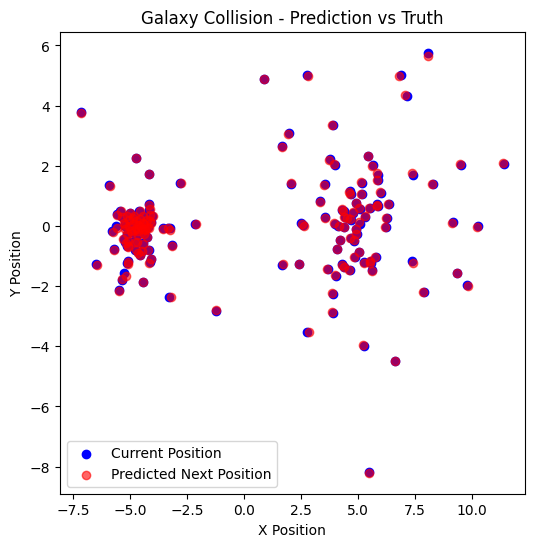

In [18]:
import torch
import matplotlib.pyplot as plt

# --- 1) Load model architecture (must match training) ---
model = GalaxyGNN(node_in=7, hidden=128, num_layers=3)
checkpoint = torch.load("/kaggle/working/gnn_galaxy.pt", map_location="cpu")

# Handle case where .pt file contains 'model_state_dict'
if "model_state_dict" in checkpoint:
    model.load_state_dict(checkpoint["model_state_dict"])
else:
    model.load_state_dict(checkpoint)

model.eval()

# --- 2) Pick a sample from dataset ---
# Make sure 'dataset' exists — if not, you must re-run preprocessing
sample = dataset[0]  

# --- 3) Predict next step ---
with torch.no_grad():
    pos_pred, vel_pred = model(sample)

# --- 4) Plot results ---
plt.figure(figsize=(6, 6))
plt.scatter(sample.x[:, 0], sample.x[:, 1], c="blue", label="Current Position")

# If ground truth exists
if sample.y is not None:
    pos_true = sample.y[:, :3]
    vel_true = sample.y[:, 3:6]
    plt.scatter(pos_true[:, 0], pos_true[:, 1], c="green", alpha=0.6, label="True Next Position")
    print("Example velocity predictions (first 5):")
    print("Predicted:", vel_pred[:5])
    print("True:", vel_true[:5])
else:
    print("⚠ No ground truth 'y' found in dataset — showing predictions only.")

plt.scatter(pos_pred[:, 0], pos_pred[:, 1], c="red", alpha=0.6, label="Predicted Next Position")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Galaxy Collision - Prediction vs Truth")
plt.show()